# 서울시 미세먼지 예측
### 데이터는 kaggle에서 가져왔다

In [66]:

library(imputeTS)
library(devtools)
library(ggmap)
library(reshape)
library(stringr)
library(dplyr)
library(tidyverse)
library(lubridate)
library(colorspace)
library(corrplot)
library(igraph)

In [74]:
setwd("C://Users/admin/Desktop/자료분석/data/")


station<-read.csv("datasets_576393_1056900_AirPollutionSeoul_Original Data_Measurement_station_info.csv",stringsAsFactors = F)
item<-read.csv("datasets_576393_1056900_AirPollutionSeoul_Original Data_Measurement_item_info.csv",stringsAsFactors = F)
info<-read.csv("Measurement_info.csv",stringsAsFactors = F)


str(info)
str(item)
str(station)

'data.frame':	3885066 obs. of  5 variables:
 $ Measurement.date : chr  "2017-01-01 00:00" "2017-01-01 00:00" "2017-01-01 00:00" "2017-01-01 00:00" ...
 $ Station.code     : int  101 101 101 101 101 101 102 102 102 102 ...
 $ Item.code        : int  1 3 5 6 8 9 1 3 5 6 ...
 $ Average.value    : num  0.004 0.059 1.2 0.002 73 57 0.006 0.068 1.3 0.002 ...
 $ Instrument.status: int  0 0 0 0 0 0 0 0 0 0 ...
'data.frame':	6 obs. of  7 variables:
 $ Item.code          : int  1 3 5 6 8 9
 $ Item.name          : chr  "SO2" "NO2" "CO" "O3" ...
 $ Unit.of.measurement: chr  "ppm" "ppm" "ppm" "ppm" ...
 $ Good.Blue.         : num  0.02 0.03 2 0.03 30 15
 $ Normal.Green.      : num  0.05 0.06 9 0.09 80 35
 $ Bad.Yellow.        : num  0.15 0.2 15 0.15 150 75
 $ Very.bad.Red.      : num  1 2 50 0.5 600 500
'data.frame':	25 obs. of  5 variables:
 $ Station.code          : int  101 102 103 104 105 106 107 108 109 110 ...
 $ Station.name.district.: chr  "Jongno-gu" "Jung-gu" "Yongsan-gu" "Eunpyeong-gu" ..

In [77]:
station.code<-table(info$Station.code)
station.code<-dimnames(station.code)[[1]]
station.code

[1] "101" "102" "103" "104" "105" "106" "107" "108" "109" "110" "111" "112"
[13] "113" "114" "115" "116" "117" "118" "119" "120" "121" "122" "123" "124"
[25] "125"

## 데이터 전처리

In [78]:
pollution_data_total<-data.frame()

for(k in station.code){

  k<-as.numeric(k)
  tmp<-info[info$Station.code==k,]
  
##status code 가 0이 아닌것들은 정상적인 데이터가 아니므로 NA로 바꾼다
tmp<-info[info$Station.code==k,]
tmp$Average.value[tmp$Instrument.status!=0]<-NA
info2<-tmp[,c(1,2,3,4)]


tmp1<-left_join(info2,item[,c(1,2)],by=c("Item.code"="Item.code"))
tmp2<-left_join(tmp1,station,by=c("Station.code"="Station.code"))



##추후 분석에 사용될수 있으므로 station, Adress, Lat, Lon 정보를 같이 저장하였습니다.
##tmp3<-tmp2[,c(1,4,5)] code 로 진행하게되면 time, so2, no2, co, o3, pm10, pm2.5 의 정보만 가져올 수 있습니다.

tmp3<-tmp2[,c(1,4,5,6,7,8,9)]
tmp3_melt<-reshape(tmp3, idvar=c("Measurement.date","Station.name.district.","Address","Latitude","Longitude"),
                  timevar="Item.name", direction="wide")

names(tmp3_melt)<-c("Time","station","Address","Lat","Lon","SO2","NO2","CO","O3","PM10","PM2.5")


date<-seq(ymd_h("2017-01-01 01"),ymd_h("2019-12-31 23"),3600)
date1<-data.frame(substr(date,1,16))

dimnames(date1)[[2]]<-c("Time")



pollution_data_station<-left_join(date1,tmp3_melt,by=c("Time"="Time"))
ind<-is.na(pollution_data_station$station)
pollution_data_station$station[ind]<-pollution_data_station$station[1]
pollution_data_station$Lat[ind]<-pollution_data_station$Lat[1]
pollution_data_station$Lon[ind]<-pollution_data_station$Lon[1]
pollution_data_station$Address[ind]<-pollution_data_station$Address[1]



name<-pollution_data_station$station[1]
cat(k,"/")

setwd("C://Users/admin/Desktop/자료분석/data/station2")
write.csv(pollution_data_station,paste0(name,".csv"),row.names = F)

pollution_data_total<-rbind.data.frame(pollution_data_total,pollution_data_station)

}


101 /102 /103 /104 /105 /106 /107 /108 /109 /110 /111 /112 /113 /114 /115 /116 /117 /118 /119 /120 /121 /122 /123 /124 /125 /

### 기상청에서 외부 데이터를 가져왔다

In [79]:

setwd("C://Users/admin/Desktop/자료분석/data/")
weather2017<-read.csv("weather2017.csv",stringsAsFactors = F)
weather2018<-read.csv("weather2018.csv",stringsAsFactors = F)
weather2019<-read.csv("weather2019.csv",stringsAsFactors = F)
str(weather2017)

weather2017<-weather2017[,c(2,3,5,7)]
weather2018<-weather2018[,c(2,3,5,7)]
weather2019<-weather2019[,c(2,3,5,7)]


'data.frame':	8760 obs. of  27 variables:
 $ 지점                  : int  108 108 108 108 108 108 108 108 108 108 ...
 $ 일시                  : chr  "2017-01-01 00:00" "2017-01-01 01:00" "2017-01-01 02:00" "2017-01-01 03:00" ...
 $ 기온..C.              : num  0.2 0 -0.3 -0.7 -1.1 -1.4 -1.5 -1.5 -1.3 -0.4 ...
 $ 강수량.mm.            : num  NA NA NA NA NA NA NA NA NA NA ...
 $ 풍속.m.s.             : num  2.2 1.4 1.9 2 1.6 1.4 1.6 1.4 1.4 1.6 ...
 $ 풍향.16방위.          : int  20 20 50 50 20 50 20 20 20 20 ...
 $ 습도...               : int  79 78 81 84 85 86 87 87 87 83 ...
 $ 증기압.hPa.           : num  4.9 4.8 4.9 4.9 4.8 4.8 4.8 4.8 4.9 4.9 ...
 $ 이슬점온도..C.        : num  -3 -3.3 -3.1 -3 -3.3 -3.4 -3.3 -3.3 -3.1 -2.9 ...
 $ 현지기압.hPa.         : num  1019 1019 1018 1019 1019 ...
 $ 해면기압.hPa.         : num  1030 1030 1029 1030 1030 ...
 $ 일조.hr.              : num  NA NA NA NA NA NA NA NA 0 0 ...
 $ 일사.MJ.m2.           : num  NA NA NA NA NA NA NA NA 0.01 0.16 ...
 $ 적설.cm.              : num  NA NA NA 

In [80]:

weather<-rbind.data.frame(weather2017,weather2018,weather2019)
names(weather)<-c("time","celsius","wind","humidity")

weather$ymd<-substr(weather$time,1,10)
celsius<-aggregate(celsius~ymd,weather, mean)
wind<-aggregate(wind~ymd,weather, mean)
humidity<-aggregate(humidity~ymd,weather, mean)

weather_mean<-cbind.data.frame(celsius,wind[,-1],humidity[,-1])
names(weather_mean)<-c("ymd","celsius","wind","humidity")
write.csv(weather_mean,"weather_mean.csv",row.names = F)



######################################################## 2 ########################################################
setwd("C://Users/admin/Desktop/자료분석/data/station2")
pollution_data_total<-read.csv("station_total.csv",stringsAsFactors = F)
pollution_data_total$ymd<-substr(pollution_data_total$Time,1,10)


### missing value가 있어서 interpolation을 사용했다

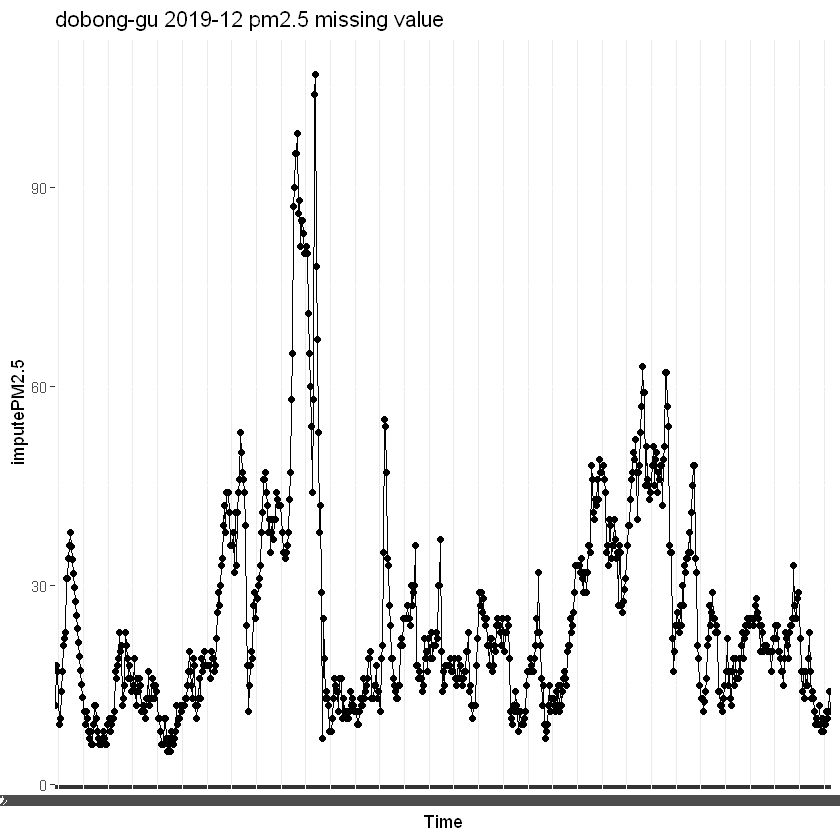

In [81]:


########################################################missing value plot
########################################################

pollution_data_station<-split(pollution_data_total,pollution_data_total$station)
pollution_data_station[[1]]$y<-substr(pollution_data_station[[1]]$Time,1,4)
pollution_data_station[[1]]$m<-substr(pollution_data_station[[1]]$Time,6,7)
pollution_data_station[[1]]$d<-substr(pollution_data_station[[1]]$Time,9,10)


##missing imputation example
pollution_data_station[[1]]$imputePM10<-na_interpolation(pollution_data_station[[1]]$PM10,option = "linear")
pollution_data_station[[1]]$imputePM2.5<-na_interpolation(pollution_data_station[[1]]$PM2.5,option = "linear")

ggplot(pollution_data_station[[1]][pollution_data_station[[1]]$y=="2019" & pollution_data_station[[1]]$m=="12",],
       aes(x=Time,y=imputePM2.5,group=1),size=0.5)+geom_point()+geom_line()+ggtitle("dobong-gu 2019-12 pm2.5 missing value")


ggsave("dobong-gu 2019-12 pm2.5 missing value.jpg",width = 10, height = 9)


In [82]:

########################################################missing imputation
########################################################

tmp7<-data.frame()

for(i in 1:25){
  
 
  pollution_data_station[[i]]$imputePM10<-na_interpolation(pollution_data_station[[i]]$PM10,option = "linear")
  pollution_data_station[[i]]$imputePM2.5<-na_interpolation(pollution_data_station[[i]]$PM2.5,option = "linear")
  pollution_data_station[[i]]$imputeSO2<-na_interpolation(pollution_data_station[[i]]$SO2,option = "linear")
  pollution_data_station[[i]]$imputeNO2<-na_interpolation(pollution_data_station[[i]]$NO2,option = "linear")
  pollution_data_station[[i]]$imputeCO<-na_interpolation(pollution_data_station[[i]]$CO,option = "linear")
  pollution_data_station[[i]]$imputeO3<-na_interpolation(pollution_data_station[[i]]$O3,option = "linear")
  
  
  
  
  PM10<-aggregate(imputePM10~ymd,pollution_data_station[[i]], mean)
  PM2.5<-aggregate(imputePM2.5~ymd,pollution_data_station[[i]], mean)
  SO2<-aggregate(imputeSO2~ymd,pollution_data_station[[i]], mean)
  NO2<-aggregate(imputeNO2~ymd,pollution_data_station[[i]], mean)
  CO<-aggregate(imputeCO~ymd,pollution_data_station[[i]], mean)
  O3<-aggregate(imputeO3~ymd,pollution_data_station[[i]], mean)
  
  
  
  pollution_mean<-cbind.data.frame(PM10,PM2.5[,-1],SO2[,-1],NO2[,-1],CO[,-1],O3[,-1])
  names(pollution_mean)<-c("ymd","PM10","PM2.5","SO2","NO2","CO","O3")
  pollution_mean$station<-pollution_data_station[[i]]$station[1]
  pollution_mean$address<-pollution_data_station[[i]]$Address[1]
  pollution_mean$Lat<-pollution_data_station[[i]]$Lat[1]
  pollution_mean$Lon<-pollution_data_station[[i]]$Lon[1]
    name<-pollution_mean$station[1]
  
  pollution_weather<-cbind.data.frame(pollution_mean,weather_mean[,-1])  
    
  setwd("C:/Users/admin/Desktop/자료분석/data/station2/impute/")
  write.csv(pollution_weather,paste0(name,"-impute.csv"),row.names=F)
  
  tmp7<-rbind.data.frame(tmp7,pollution_weather)
  
  
  
  cat(i,"\n")
}


1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 


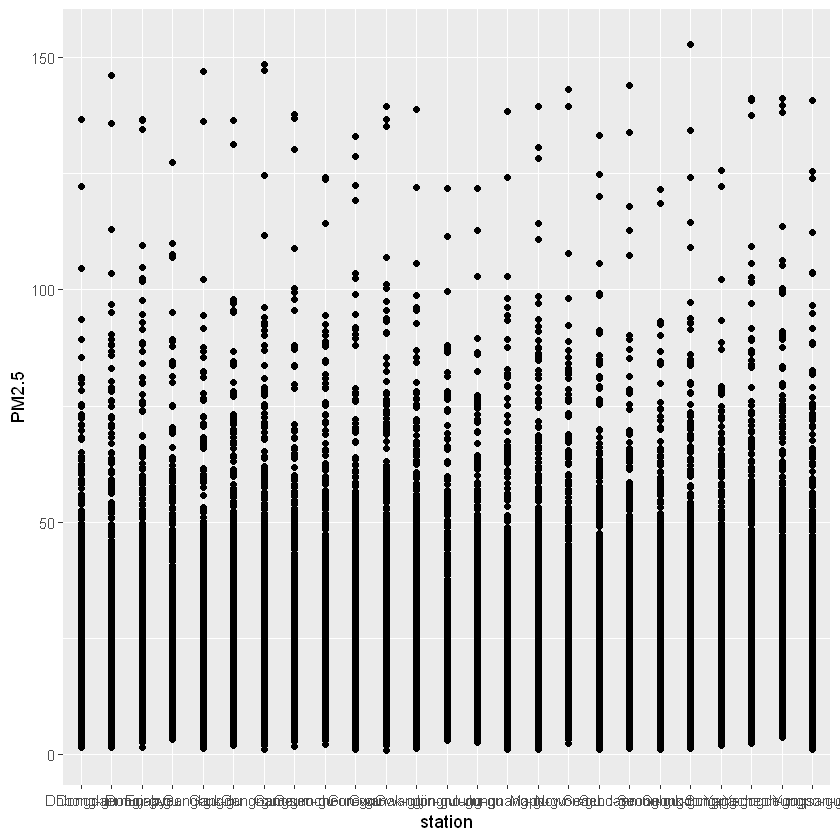

In [41]:

 ggplot(data=tmp7,aes(x=station,y=PM2.5))+geom_point()


In [83]:
setwd("C:/Users/admin/Desktop/자료분석/data/station2/impute/")

dat<-read.csv("pollution_mean.csv",stringsAsFactors = F)
dat$y<-substr(dat$ymd,1,4)
dat$m<-substr(dat$ymd,6,7)
dat$ym<-substr(dat$ymd,1,7)
dat_list<-split(dat,dat$station)
dat2<-dat[,c(2,8)]

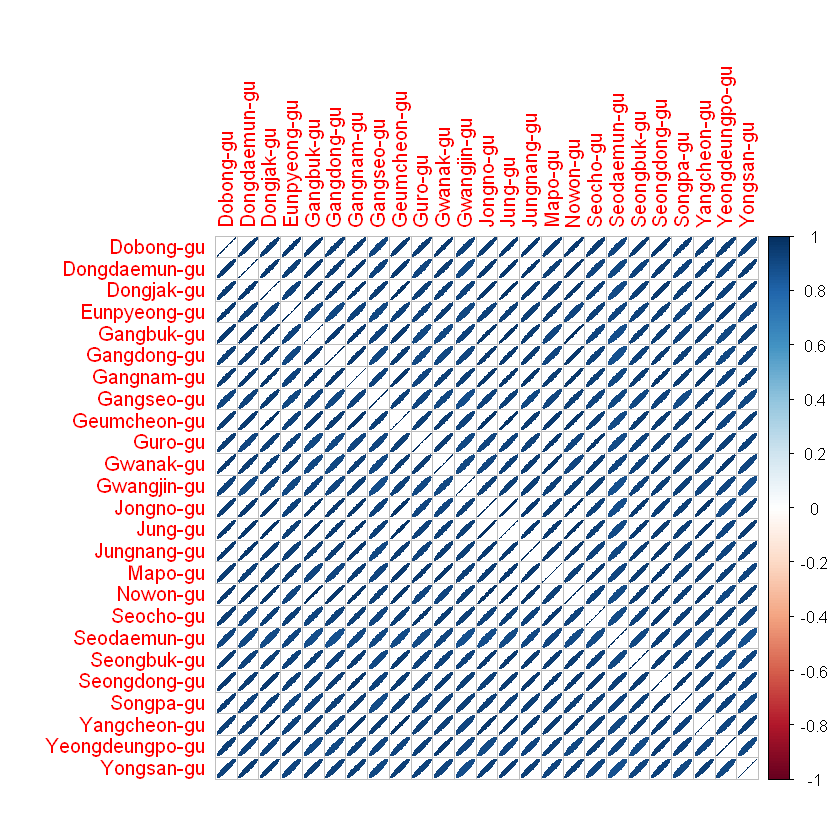

In [84]:

######################################################## correalation 
######################################################## pm2.5

dat_cbind<-data.frame(dat_list[[1]]$PM2.5)
station<-dat_list[[1]]$station[[1]]
names(dat_cbind)<-paste0(station)

for(i in 2:25){

  tmp8<-data.frame(dat_list[[i]]$PM2.5)
  station<-dat_list[[i]]$station[[1]]
  
  names(tmp8)<-paste0(station)  
  dat_cbind<-cbind(dat_cbind,tmp8)
  
  
}
 
station_cor<-cor(dat_cbind)
corrplot(station_cor,method="ellipse")


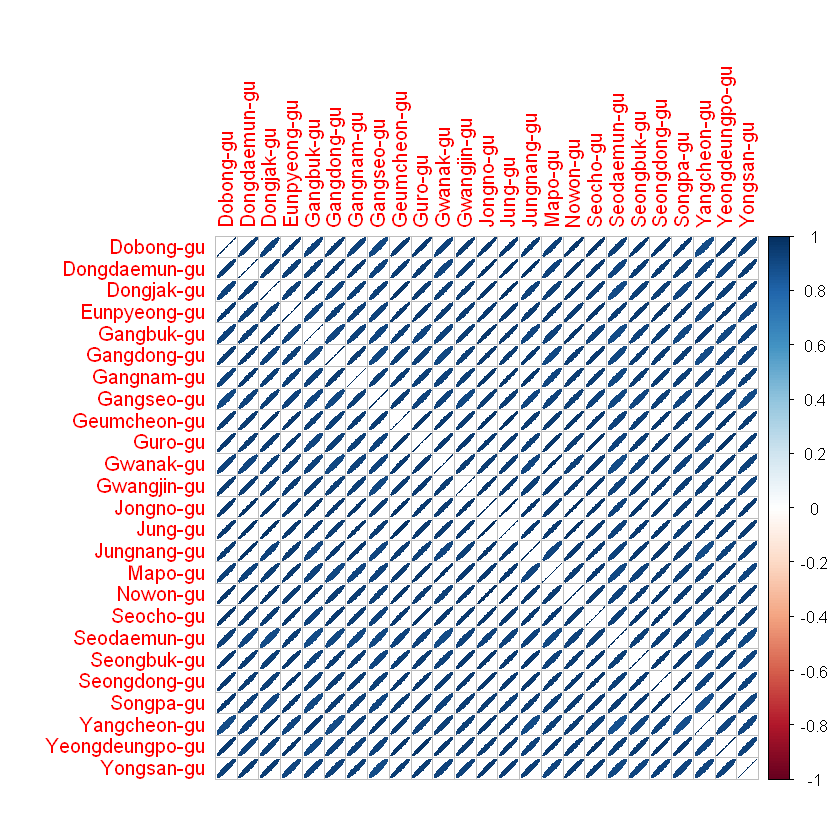

In [85]:
######################################################## correalation 
######################################################## pm10
dat_cbind<-data.frame(dat_list[[1]]$PM10)
station<-dat_list[[1]]$station[[1]]
names(dat_cbind)<-paste0(station)

for(i in 2:25){
  
  tmp8<-data.frame(dat_list[[i]]$PM10)
  station<-dat_list[[i]]$station[[1]]
  
  names(tmp8)<-paste0(station)  
  dat_cbind<-cbind(dat_cbind,tmp8)
  
  
}

station_cor<-cor(dat_cbind)
corrplot(station_cor,method="ellipse")


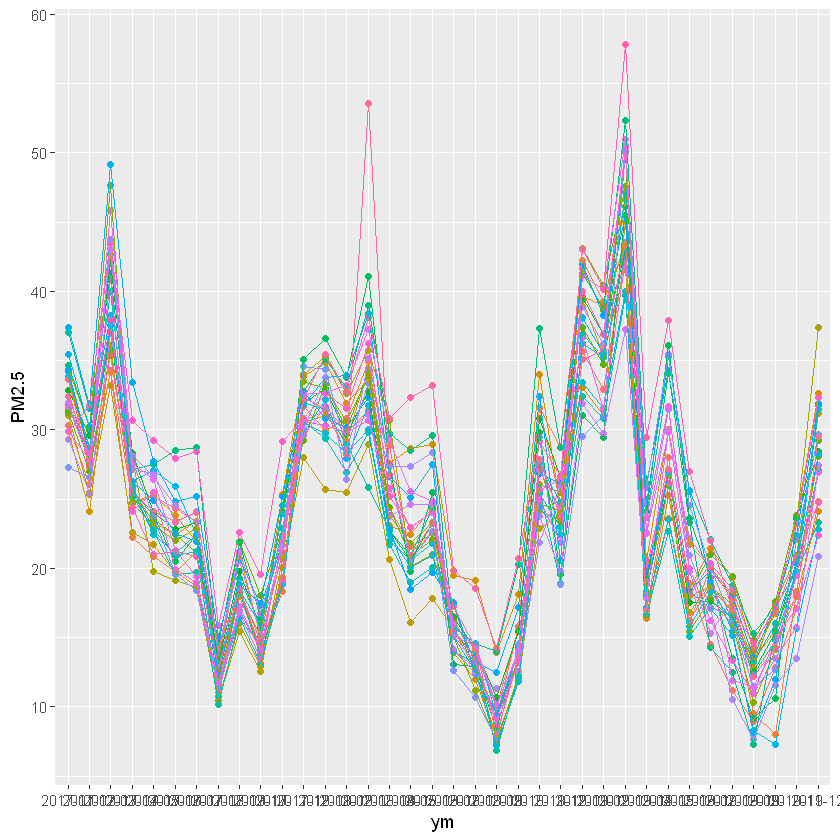

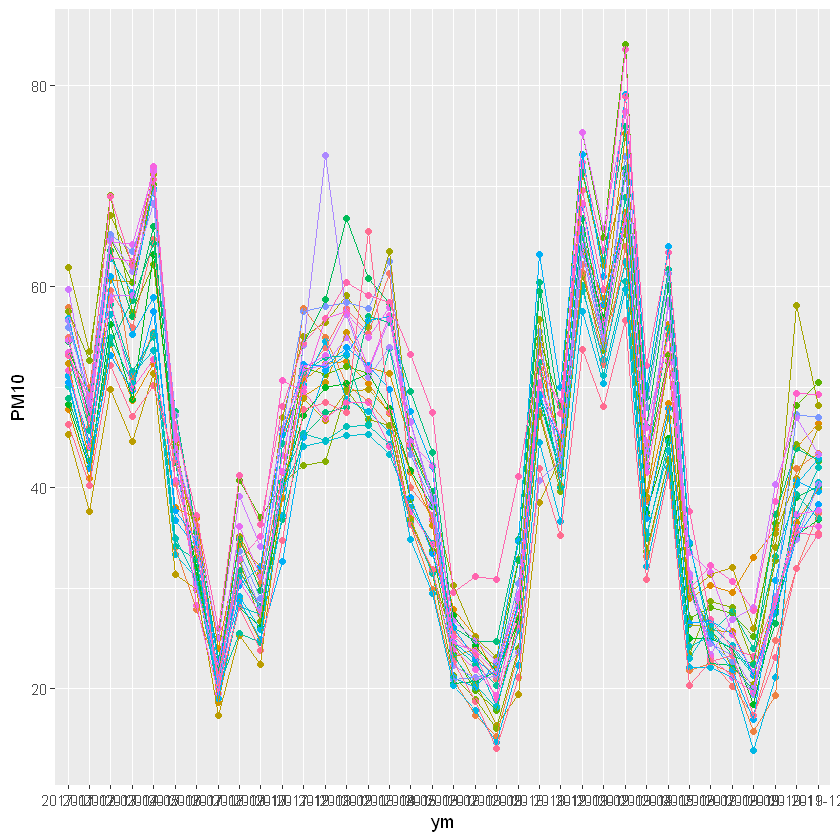

In [64]:

######################################################## station 월평균 plot
########################################################

tmp10<-data.frame()

for(i in 1:25){
  PM10<-aggregate(PM10~ym,dat_list[[i]], mean)
  PM2.5<-aggregate(PM2.5~ym,dat_list[[i]], mean)
  SO2<-aggregate(SO2~ym,dat_list[[i]], mean)
  NO2<-aggregate(NO2~ym,dat_list[[i]], mean)
  CO<-aggregate(CO~ym,dat_list[[i]], mean)
  O3<-aggregate(O3~ym,dat_list[[i]], mean)
  
  
  
  tmp9<-cbind.data.frame(PM10,PM2.5[,-1],SO2[,-1],NO2[,-1],CO[,-1],O3[,-1])
  names(tmp9)<-c("ym","PM10","PM2.5","SO2","NO2","CO","O3")
  tmp9$station<-dat_list[[i]]$station[1]
  tmp9$address<-dat_list[[i]]$Address[1]
  tmp9$Lat<-dat_list[[i]]$Lat[1]
  tmp9$Lon<-dat_list[[i]]$Lon[1]
  name<-tmp9$station[1]
  
  tmp10<-rbind.data.frame(tmp10,tmp9)
  
}


ggplot(data=tmp10,aes(x=ym,y=PM2.5,color=station,group=station))+geom_point()+geom_path()+
  theme(legend.position = "none")

ggplot(data=tmp10,aes(x=ym,y=PM10,color=station,group=station))+geom_point()+geom_path()+
  theme(legend.position = "none")



Warning message in `[<-.factor`(`*tmp*`, ri, value = c(53.1140474520804, 45.83, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(32.5070546984572, 28.3297619047619, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(0.00495723352033661, 0.00502872023809524, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(0.0349318443197756, 0.0347897619047619, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(0.677693782141187, 0.632702380952381, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(0.0141392484805984, 0.0182529761904762, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(-1.76787634408602, -0.269642857142857, :
"invalid factor level, NA generated"Warning message in `[<-.factor`(`*tmp*`, ri, value = c(2.29475806451613, 2.44895833333333

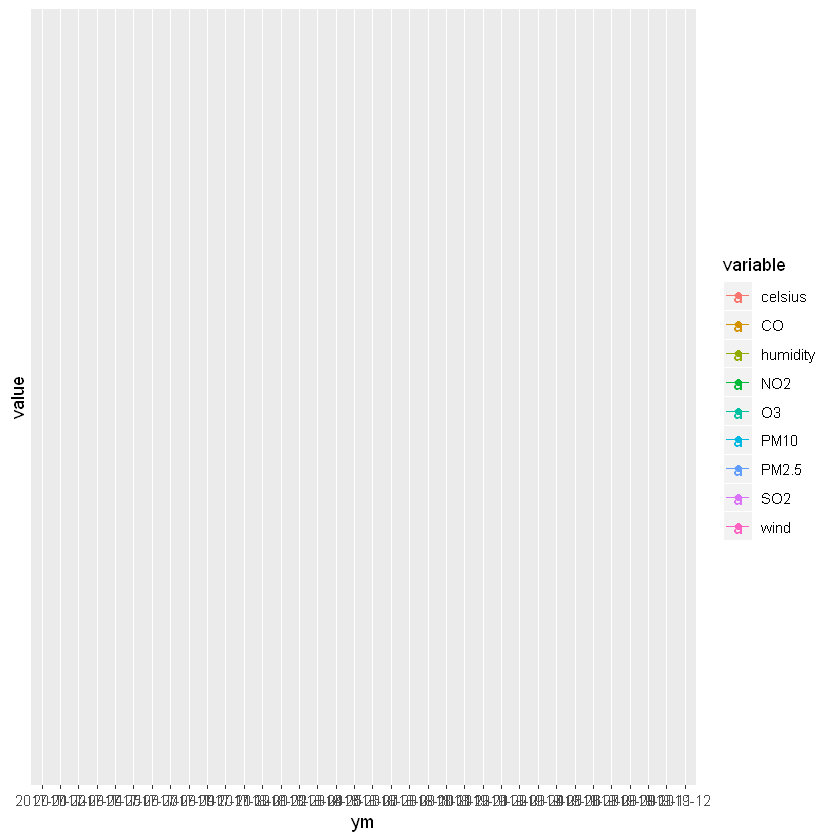

In [87]:

  PM10<-aggregate(PM10~ym,dat, mean)
  PM2.5<-aggregate(PM2.5~ym,dat, mean)
  SO2<-aggregate(SO2~ym,dat, mean)
  NO2<-aggregate(NO2~ym,dat, mean)
  O3<-aggregate(O3~ym,dat, mean)
  CO<-aggregate(CO~ym,dat, mean)
  celsius<-aggregate(celsius~ym,dat, mean)
  humidity<-aggregate(humidity~ym,dat, mean)
  wind<-aggregate(wind~ym,dat, mean)
  
  
  
  
  tmp11<-cbind.data.frame(PM10,PM2.5[,-1],SO2[,-1],NO2[,-1],CO[,-1],O3[,-1],celsius[,-1],wind[,-1],humidity[,-1])
  names(tmp11)<-c("ym","PM10","PM2.5","SO2","NO2","CO","O3","celsius","wind","humidity")

 tmp11_melt<- melt(data = tmp11,id.vars = "ym",
                             measure.vars = c("ym","PM10","PM2.5","SO2","NO2","CO","O3","celsius","wind","humidity"))
tmp11_melt<- tmp11_melt[-c(1:36),]
tmp11_melt$variable<-as.character(tmp11_melt$variable)
tmp11_melt$value<-as.numeric(tmp11_melt$value)
tmp11_text<-tmp11_melt[c(1,38,74,112,148,185,225,260,300),]



ggplot(data=tmp11_melt,aes(x=ym,y=value,color=variable,group=variable))+
  geom_point()+geom_path()+ geom_text(data=tmp11_text,aes(x=ym,y=as.numeric(value),hjust=0.1,
                                                          label=paste0(as.character(variable))))




